In [1]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import warnings
from matplotlib.colors import PowerNorm

from plotting_tools import * 

In [2]:
def calculate_elementary_effects(sensitivity_result_file, parameters, num_sims, deviations):
    rows = []
    for param in parameters:
        # Get base values
        base_new_inf = []
        base_peak_height = []
        base_peak_time = []
        for sim in range(num_sims):
            output = pd.read_csv(sensitivity_result_file + f"{param}/1.0/{sim}_output.csv", sep = " ")
            output.columns = list(output.columns[1:]) + ['Unnamed']
            output['t'] = output.index
            output['Prevalence'] = output.E + output.Ins + output.Isy + output.Isev + output.Icri
            new_infected = output.NewInf[1:].sum()
            peak_height = output.Prevalence.max()
            peak_time = output[output.Prevalence == peak_height].t.iloc[0]
            base_new_inf.append(new_infected)
            base_peak_height.append(peak_height)
            base_peak_time.append(peak_time)
        # Get deviation values
        for dev in deviations:
            if dev == 1.0:
                continue
            for sim in range(num_sims):
                output = pd.read_csv(sensitivity_result_file + f"/{param}/{dev}/{sim}_output.csv", sep = " ")
                output.columns = list(output.columns[1:]) + ['Unnamed']
                output['t'] = output.index
                output['Prevalence'] = output.E + output.Ins + output.Isy + output.Isev + output.Icri
                new_infected = output.NewInf[1:].sum()
                peak_height = output.Prevalence.max()
                peak_time = output[output.Prevalence == peak_height].t.iloc[0]
                row = {"Sim": sim, "Param": param, "Dev": dev - 1.0, "Elem effect new inf": (new_infected - base_new_inf[sim])/(dev - 1.0), "Elem effect peak height": (peak_height - base_peak_height[sim])/(dev - 1.0), "Elem effect peak time": (peak_time - base_peak_time[sim])/(dev - 1.0), "Rel change new inf": (new_infected - base_new_inf[sim])/base_new_inf[sim], "Rel change peak height": (peak_height - base_peak_height[sim])/base_peak_height[sim], "Rel change peak time": (peak_time - base_peak_time[sim])/base_peak_time[sim]}
                rows.append(row)
                
    return pd.DataFrame(rows)

In [ ]:
result_file = "sensitivity_analysis/"
params = ['mu_Ins_Isy', 'T_E', 'T_infected', 'vl_peak']
deviations = [0.8, 0.9, 1.0, 1.1, 1.2]
num_sims = 100

df = calculate_elementary_effects(result_file, params, num_sims, deviations)

param_dict = {'vl_peak': r'$v_{\max}^{\text{sy}}$', 'T_E': r'$\tau_E$', 'T_infected': r'$\tau_{infectious}$', 'mu_Ins_Isy': r'$\mu_{I_{\text{ns}}}^{I_{\text{sy}}}$'}
output_dict = {'new inf': 'Summed\ntransmissions', 'peak height': 'Maximum\nprevalence', 'peak time': 'Time point of\nmaximum prevalence'}
param_colors = {'vl_peak': colors['Orange'], 'T_E': colors['Dark grey'], 'T_infected': colors['Dark red'], 'mu_Ins_Isy': colors['Medium grey']}
output_colors = {'new inf': colors['Purple'], 'peak height': colors['Green'], 'peak time': colors['Teal']}

C:\Users\bick_ju\AppData\Local\Temp\ipykernel_18912\4116772312.py:13: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  new_infected = output.NewInf[1:].sum()
C:\Users\bick_ju\AppData\Local\Temp\ipykernel_18912\4116772312.py:13: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  new_infected = output.NewInf[1:].sum()
C:\Users\bick_ju\AppData\Local\Temp\ipykernel_18912\4116772312.py:13: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  new_infected = output.NewInf[1:].sum()
C:\Users\bick_ju\AppData\Local\Temp\i

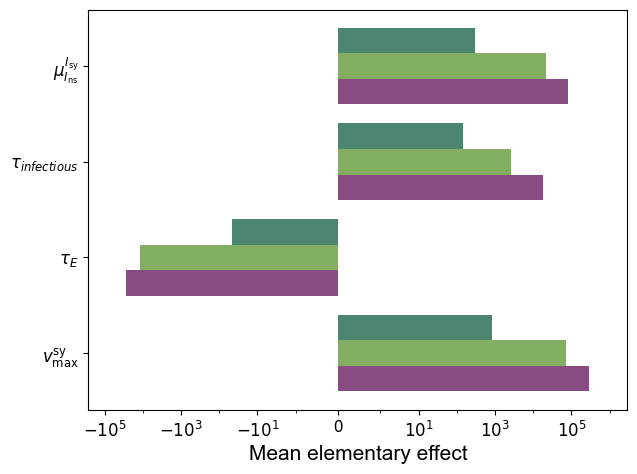

In [4]:
means = {key: [] for key in param_dict.keys()}
for o in output_dict.keys():
    df_o = pd.DataFrame()
    for param in param_dict.keys():
        values = list(df[df.Param == param][f'Elem effect {o}'].iloc[:])
        df_o[param] = values
    for key in df_o.columns:
        means[key].append(df_o[key].mean())

width_in_in = 6.2
height_in_in = 5

figsize = (width_in_in, height_in_in)
keys = list(means.keys())
n_groups = len(keys)
n_bars = len(means[keys[0]])  # number of bars per group

bar_width = 0.8 / n_bars  # total group height divided by number of bars
y = np.arange(n_groups)    # center positions for each group

fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0.125, 0.18, 0.87, 0.8])
handles = []
labels = []

for i in range(n_bars):
    # Compute positions for each bar in the group (now along y-axis)
    y_pos = y - 0.4 + i * bar_width + bar_width / 2
    # Lengths of the bars (take i-th element from each key)
    lengths = [means[key][i] for key in keys]
    bars = ax.barh(y_pos, lengths, height=bar_width, color=list(output_colors.values())[i])
    handles.append(bars[0])  # only need one handle per bar group
    labels.append(list(output_dict.values())[i])  # label for legend

# Y-axis labels (group names)
ax.set_yticks(y)
ax.set_yticklabels(param_dict[key] for key in keys)

# Axis labels
powers = [1, 3, 5]
ticks_plus = [10**p for p in powers]
ticks_minus = [-10**p for p in reversed(powers)]
ticks = ticks_minus + [0] + ticks_plus
tick_labels_plus = [r"$10^{{{}}}$".format(int(v)) for v in powers]
tick_labels_minus = [r"$-10^{{{}}}$".format(int(v)) for v in reversed(powers)]
tick_labels = tick_labels_minus + ['0'] + tick_labels_plus
ax.set_xlabel("Mean elementary effect")
ax.set_xscale('symlog', linthresh=1)
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)

# Limits
all_values = [v for sublist in means.values() for v in sublist]
overall_min = min(all_values)
overall_max = max(all_values)
ax.set_xlim(overall_min * 10, overall_max * 10)
plt.show()
fig.savefig(f'Elem_effects_means_barh.png', dpi=dpi)

fig_leg = plt.figure(figsize=(width_in_in, height_in_in/5))
fig_leg.legend(handles, labels, loc='center', ncol=n_bars)
plt.tight_layout()
fig_leg.savefig(f'Elem_effects_means_legend.png', dpi=dpi)
plt.close(fig_leg)

In [7]:
def calculate_max_corr(parameters, deviations, num_sims):
    max_lag = 720
    rows = []
    for param in parameters:
        print(param)
        for dev in deviations:
            print(dev)
            # Read in first simulation to get the number of time points
            output = pd.read_csv(result_file + f"/{param}/{dev}/0_output.csv", sep = " ")
            output.columns = list(output.columns[1:]) + ['Unnamed']
            output['t'] = output.index
            output['Prevalence'] = output.E + output.Ins + output.Isy + output.Isev + output.Icri
            num_time_points = len(output.t.unique())
            prevalence = np.zeros((num_sims, num_time_points))
            shedding = np.zeros((num_sims, num_time_points))
            corr = np.zeros((num_sims, 2 * (max_lag + 1)))
            prevalence[0, :] = output.Prevalence.iloc[:]
            shedding[0, :] = output.Shedding.iloc[:]
            for lag in range(-max_lag, max_lag + 1, 1):
                corr[0, lag + max_lag] = output.Shedding.corr(output.Prevalence.shift(lag))
            for sim in range(1, num_sims):
                output = pd.read_csv(result_file + f"/{param}/{dev}/{sim}_output.csv", sep = " ")
                output.columns = list(output.columns[1:]) + ['Unnamed']
                output['t'] = output.index
                output['Prevalence'] = output.E + output.Ins + output.Isy + output.Isev + output.Icri
                prevalence[sim, :] = output.Prevalence.iloc[:]
                shedding[sim, :] = output.Shedding.iloc[:]
                for lag in range(-max_lag, max_lag + 1, 1):
                    corr[sim, lag + max_lag] = output.Shedding.corr(output.Prevalence.shift(lag))
            max_corr = corr.mean(axis=0).max()
            lag_of_max_corr = list(corr.mean(axis=0)).index(max_corr) - max_lag
            row = {"Param": param, "Dev": dev, "Max corr": max_corr, "Lag of max corr": lag_of_max_corr}
            rows.append(row)
            
    return pd.DataFrame(rows)

In [24]:
df1 = calculate_max_corr(params, deviations, num_sims)

mu_Ins_Isy
0.8
0.9
1.0
1.1
1.2
T_E
0.8
0.9
1.0
1.1
1.2
T_infected
0.8
0.9
1.0
1.1
1.2
vl_peak
0.8
0.9
1.0
1.1
1.2


In [25]:
df_corr = df1
df_corr.Dev = np.round((1 - df_corr.Dev)*100)
df_corr["Dev"] = df_corr["Dev"].astype(int)
df_corr["Lag of max corr"] = df_corr["Lag of max corr"].astype(float) / 24.

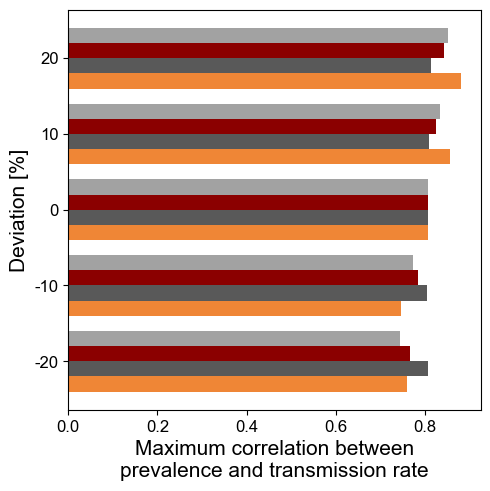

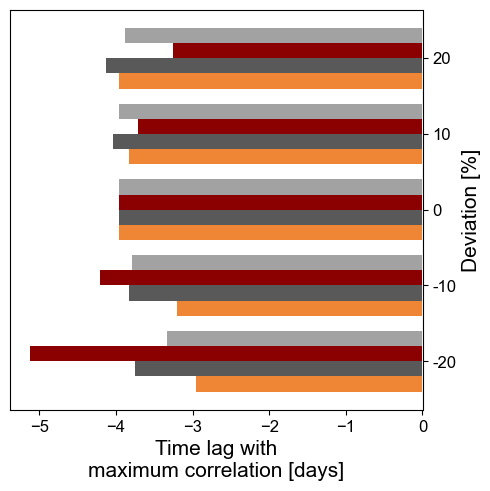

In [27]:
width_in_in = 5.5
height_in_in = 5
# Create grouped bar plots
df_corr = df_corr.sort_values("Dev")
# Pivot so rows are Dev and columns are parameters
pivot_df = df_corr.pivot(index="Dev", columns="Param", values="Max corr")
ordered_cols = list(param_dict.keys())
pivot_df = pivot_df[ordered_cols]
# Number of groups (Dev) and number of bars per group
n_groups = len(pivot_df.index)
n_bars = len(ordered_cols)
bar_width = 0.8 / n_bars  # total bar width divided by number of bars

fig = plt.figure(figsize=(width_in_in, height_in_in))
ax = fig.add_axes([0.13, 0.18, 0.75, 0.8])

# Compute bar positions for each parameter (now along y-axis)
y = np.arange(n_groups)  # positions for group centers
for i, col in enumerate(ordered_cols):
    # Bar positions within the group
    y_pos = y - 0.4 + i * bar_width + bar_width / 2
    ax.barh(y_pos, pivot_df[col].values, height=bar_width, color=param_colors[col])

# Set y-ticks and labels
ax.set_yticks(y)
ax.set_yticklabels([str(dev) for dev in pivot_df.index])
ax.set_ylabel("Deviation [%]")
ax.set_xlabel("Maximum correlation between\nprevalence and transmission rate")
plt.show()
fig.savefig("max_correlations_barh.png", dpi=dpi)
plt.close(fig)

# Bar plot for lags
pivot_df = df_corr.pivot(index="Dev", columns="Param", values="Lag of max corr")
ordered_cols = list(param_dict.keys())
pivot_df = pivot_df[ordered_cols]
fig = plt.figure(figsize=(width_in_in, height_in_in))
ax = fig.add_axes([0.13, 0.18, 0.75, 0.8])

# Compute bar positions for each parameter (now along y-axis)
y = np.arange(n_groups)  # positions for group centers
for i, col in enumerate(ordered_cols):
    # Bar positions within the group
    y_pos = y - 0.4 + i * bar_width + bar_width / 2
    ax.barh(y_pos, pivot_df[col].values, height=bar_width, color=param_colors[col])

# Set y-ticks and labels
ax.set_yticks(y)
ax.set_yticklabels([str(dev) for dev in pivot_df.index])
ax.set_ylabel("Deviation [%]")
ax.yaxis.tick_right()           # Moves ticks to the right side
ax.yaxis.set_label_position('right') 
ax.set_xlabel("Time lag with\nmaximum correlation [days]")
plt.show()
fig.savefig("max_corr_lags_barh.png", dpi=dpi)
plt.close(fig)

# Create separate legend figure
handles = []
for col in ordered_cols:
    # Rectangle for the bar
    bar_handle = matplotlib.patches.Rectangle((0,0),1,1, color=param_colors[col])
    # Combine in a list as a custom handle
    handles.append((bar_handle))

# Build legend with custom handler
from matplotlib.legend_handler import HandlerTuple
fig_leg = plt.figure(figsize=(width_in_in, height_in_in/5))
fig_leg.legend(
    handles, 
    [param_dict[col] for col in ordered_cols], 
    handler_map={tuple: HandlerTuple()},
    loc='center', ncol=4
)
plt.tight_layout()
fig_leg.savefig("legend_bars.png", dpi=dpi)
plt.close(fig_leg)